In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def get_high_low_loaders(data_set):
  train_idx_h = [h for h in range(len(data_set.targets)) if data_set.targets[h] == 0]
  train_idx_l = [l for l in range(len(data_set.targets)) if data_set.targets[l] == 1]

  # high resolution
  train_set_h = torch.utils.data.Subset(data_set, train_idx_h)
  train_loader_h = torch.utils.data.DataLoader(dataset=train_set_h, batch_size=batch_size, shuffle=False)

  # low resolution
  train_set_l = torch.utils.data.Subset(data_set, train_idx_l)
  train_loader_l = torch.utils.data.DataLoader(dataset=train_set_l, batch_size=batch_size, shuffle=False)

  return train_loader_h, train_loader_l


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32

img_transform = transform.Compose([transform.ToTensor()]) 

# Training Set
train_set =  torchvision.datasets.ImageFolder('/content/drive/MyDrive/UTEC/ciclo2/Aprendizaje Automático/Semana13_PROY4_Autoencoders/dataset/train/', img_transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(train_set)

# Testing Set
test_set =  torchvision.datasets.ImageFolder('/content/drive/MyDrive/UTEC/ciclo2/Aprendizaje Automático/Semana13_PROY4_Autoencoders/dataset/val/', img_transform)
# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(test_set)

cuda:0
Dataset ImageFolder
    Number of datapoints: 1370
    Root location: /content/drive/MyDrive/UTEC/ciclo2/Aprendizaje Automático/Semana13_PROY4_Autoencoders/dataset/train/
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 340
    Root location: /content/drive/MyDrive/UTEC/ciclo2/Aprendizaje Automático/Semana13_PROY4_Autoencoders/dataset/val/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
_features = 12

In [ ]:
utils.size_output_layer(256,3,1,1)

256

In [ ]:
utils.size_output_layer(32,4,2,1)

16

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), #salida 
      #nn.BatchNorm2d(64),#out_channels
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1), #salida 128
      #nn.BatchNorm2d(64*2),
      nn.ReLU()
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(in_channels=64*2, out_channels=64*2*2, kernel_size=4, stride=2, padding=1), # salida 32
      #nn.BatchNorm2d(64*2*2),
      nn.ReLU()
    )

    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=64*2*2, out_channels=64*2*2*2, kernel_size=4, stride=2, padding=1), 
        #nn.BatchNorm2d(64*2*2),
        nn.ReLU()
    )

    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64*2*2*2, out_channels=64*2*2*2*2, kernel_size=4, stride=2, padding=1), 
        #nn.BatchNorm2d(64*2*2),
        nn.ReLU()
    )

    self.fc = nn.Linear(in_features=64*2*2*2*2*16*16, out_features=_features)

  def forward(self, image):
    self.out1 = F.relu(self.conv1(image))
    self.out2 = F.relu(self.conv2(self.out1))
    self.out3 = F.relu(self.conv3(self.out2))
    self.out4 = F.relu(self.conv4(self.out3))
    self.out5 = F.relu(self.conv5(self.out4))
    self.out6 = self.out5.view(self.out5.size(0), -1)
    z = self.fc(self.out6)
    return z

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc    = nn.Linear(in_features=_features,out_features=64*2*2*2*2*16*16)
    self.convTran1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*64*2*2*2*2,out_channels=64*2*2*2, kernel_size=4, stride=2, padding=1),
        #nn.BatchNorm2d(64*2),
        nn.ReLU()
    )
    self.convTran2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*64*2*2*2,out_channels=64*2*2, kernel_size=4, stride=2, padding=1),
        #nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.convTran3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*64*2*2,out_channels=64*2, kernel_size=4, stride=2, padding=1),
        #nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.convTran4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*64*2,out_channels=64, kernel_size=4, stride=2, padding=1),
        #nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.convTran5 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*64,out_channels=3, kernel_size=3, stride=1, padding=1),
        #nn.BatchNorm2d(3),
        nn.ReLU()
    )
   
  def forward(self, latent, encoder):
    out = self.fc(latent)
    out = out.view(out.size(0), 64*2*2*2*2, 16, 16)

    out = F.relu(self.convTran1(torch.cat([out, encoder.out5], dim=1)))
    out = F.relu(self.convTran2(torch.cat([out, encoder.out4], dim=1)))
    out = F.relu(self.convTran3(torch.cat([out, encoder.out3], dim=1)))
    out = F.relu(self.convTran4(torch.cat([out, encoder.out2], dim=1)))

    out = torch.tanh(self.convTran5(torch.cat([out, encoder.out1], dim=1)))

    return out


In [ ]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent, self.encoder)
        return  x_recon

In [ ]:
def train(model, images_set, Epochs, loss_fn):

    images_high_loader, images_low_loader = get_high_low_loaders(images_set)

    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0

      images_high_it = iter(images_high_loader)
    
      for image_batch, _ in tqdm(images_low_loader):
          image_batch = image_batch.to(device)
          
          image_batch_recon = model(image_batch)

          image_batch_high, _ = next(images_high_it)
          image_batch_high = image_batch_high.to(device)
          
          loss = loss_fn(image_batch_recon, image_batch_high)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg

In [ ]:
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

loss_result = train(autoencoder, train_set, 20, loss)

100%|██████████| 22/22 [01:28<00:00,  4.01s/it]


Epoch [1 / 50] average reconstruction error: 0.212619


100%|██████████| 22/22 [01:25<00:00,  3.90s/it]


Epoch [2 / 50] average reconstruction error: 0.027552


100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


Epoch [3 / 50] average reconstruction error: 0.007038


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [4 / 50] average reconstruction error: 0.003918


100%|██████████| 22/22 [01:25<00:00,  3.90s/it]


Epoch [5 / 50] average reconstruction error: 0.002700


100%|██████████| 22/22 [01:25<00:00,  3.90s/it]


Epoch [6 / 50] average reconstruction error: 0.002165


100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


Epoch [7 / 50] average reconstruction error: 0.001889


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [8 / 50] average reconstruction error: 0.001762


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [9 / 50] average reconstruction error: 0.001626


100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


Epoch [10 / 50] average reconstruction error: 0.001549


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [11 / 50] average reconstruction error: 0.001498


100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


Epoch [12 / 50] average reconstruction error: 0.001448


100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


Epoch [13 / 50] average reconstruction error: 0.001379


100%|██████████| 22/22 [01:25<00:00,  3.89s/it]


Epoch [14 / 50] average reconstruction error: 0.001354


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [15 / 50] average reconstruction error: 0.001315


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [16 / 50] average reconstruction error: 0.001316


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [17 / 50] average reconstruction error: 0.001276


100%|██████████| 22/22 [01:25<00:00,  3.88s/it]


Epoch [18 / 50] average reconstruction error: 0.001262


100%|██████████| 22/22 [01:25<00:00,  3.87s/it]


Epoch [19 / 50] average reconstruction error: 0.001254


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [20 / 50] average reconstruction error: 0.001236


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [21 / 50] average reconstruction error: 0.001206


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [22 / 50] average reconstruction error: 0.001230


100%|██████████| 22/22 [01:24<00:00,  3.84s/it]


Epoch [23 / 50] average reconstruction error: 0.001195


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [24 / 50] average reconstruction error: 0.001173


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [25 / 50] average reconstruction error: 0.001218


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [26 / 50] average reconstruction error: 0.001168


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [27 / 50] average reconstruction error: 0.001169


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [28 / 50] average reconstruction error: 0.001167


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [29 / 50] average reconstruction error: 0.001134


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [30 / 50] average reconstruction error: 0.001160


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [31 / 50] average reconstruction error: 0.001125


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [32 / 50] average reconstruction error: 0.001154


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [33 / 50] average reconstruction error: 0.001131


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [34 / 50] average reconstruction error: 0.001114


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [35 / 50] average reconstruction error: 0.001127


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [36 / 50] average reconstruction error: 0.001117


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [37 / 50] average reconstruction error: 0.001116


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [38 / 50] average reconstruction error: 0.001110


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [39 / 50] average reconstruction error: 0.001118


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [40 / 50] average reconstruction error: 0.001102


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [41 / 50] average reconstruction error: 0.001087


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [42 / 50] average reconstruction error: 0.001131


100%|██████████| 22/22 [01:24<00:00,  3.85s/it]


Epoch [43 / 50] average reconstruction error: 0.001096


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [44 / 50] average reconstruction error: 0.001078


100%|██████████| 22/22 [01:25<00:00,  3.87s/it]


Epoch [45 / 50] average reconstruction error: 0.001078


100%|██████████| 22/22 [01:25<00:00,  3.87s/it]


Epoch [46 / 50] average reconstruction error: 0.001092


100%|██████████| 22/22 [01:25<00:00,  3.87s/it]


Epoch [47 / 50] average reconstruction error: 0.001083


100%|██████████| 22/22 [01:24<00:00,  3.86s/it]


Epoch [48 / 50] average reconstruction error: 0.001098


100%|██████████| 22/22 [01:25<00:00,  3.87s/it]


Epoch [49 / 50] average reconstruction error: 0.001073


100%|██████████| 22/22 [01:25<00:00,  3.87s/it]

Epoch [50 / 50] average reconstruction error: 0.001070


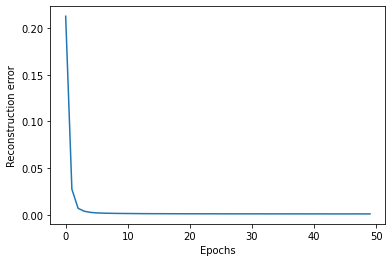

In [ ]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
test_high_loader, test_low_loader = get_high_low_loaders(test_set)

autoencoder.eval()

with torch.no_grad():
  image, label = iter(test_low_loader).next()

  image = image.to(device)
  label = label.to(device)

  z = autoencoder.encoder(image)
  z = z.to(device)

  decodificado = autoencoder.decoder(z, autoencoder.encoder)
  decodificado = decodificado.to('cpu')

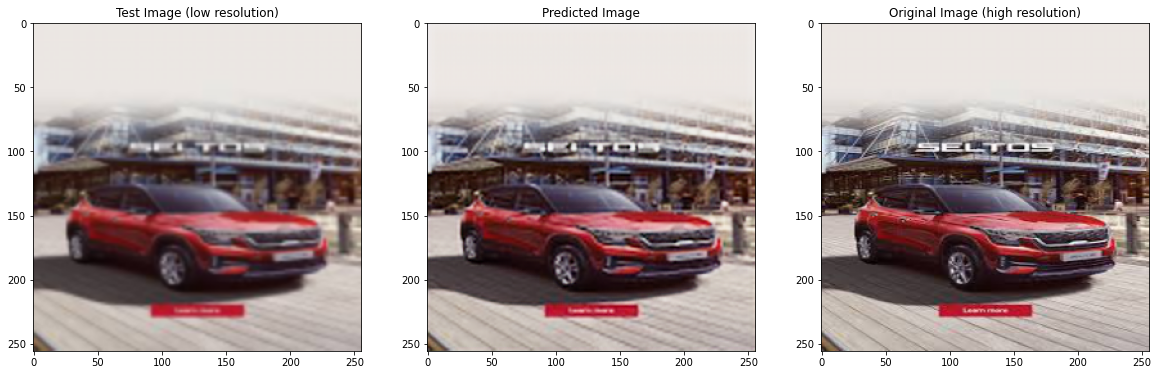

In [ ]:
idx_img = 1;
images_l, _ = iter(test_low_loader).next()
images_h, _ = iter(test_high_loader).next()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20, 20))
ax0.set_title('Test Image (low resolution)')
ax0.imshow(transform.ToPILImage()(images_l[idx_img]))

ax1.set_title('Predicted Image')
ax1.imshow(transform.ToPILImage()(decodificado[idx_img]))

ax2.set_title('Original Image (high resolution)')
ax2.imshow(transform.ToPILImage()(images_h[idx_img]))